In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [4]:
from class_ou import OU, ou_gradient

In [5]:
import pickle

with open('EX02_OU', 'rb') as f:
    true_sde = pickle.load(f)
    obs = pickle.load(f)
    obs_time = pickle.load(f)
    obs_sigma = pickle.load(f)
    sde_sigma = pickle.load(f)

In [6]:
torch.set_default_dtype(torch.float64)

**Note that the diffusion simulation based on Euler-Maruyama results in very smooth plot once dt > 2.**

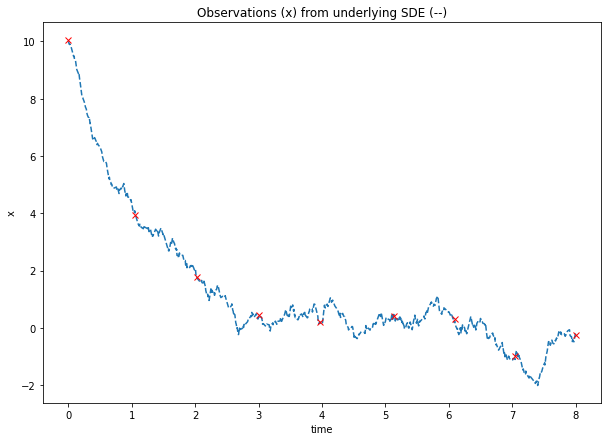

In [7]:
plt.figure(figsize=(10, 7))
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

Variational inference: KL

In [8]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma =  ou.alpha, ou.beta, ou.sigma
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = lambda z: (1 + beta) * (1 - beta) * (z ** 2) + (2 * alpha * (beta ** 2) + ((beta - 1) * (sigma ** 2))) * z
        
        num = func_kl(self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma**2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        
        D = self.alpha.shape[0]
        z0 = self.ou.z0
        z1 = self.ou.trj[:, -1].reshape(D, 1)
        """
            t is tensor
        """
        t0 = self.ou.t0.repeat(D, 1)
        t1 = self.ou.t1.repeat(D, 1)
        
        # Obtain the rest 
        def A(u):
            return (beta - 1) * (u ** 2) / (2 * (sigma ** 2))  - (alpha * beta * u / (sigma ** 2))
        
        return A(z1) - A(z0) + 0.5 * (t1 - t0) * alpha * beta * (1 + alpha * beta / (sigma ** 2))
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
        
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [9]:
import tqdm as tq

Black box variatioanl inference for SDE

In [10]:
D = 100
S = 80

# If learning rate is high, then beta explodes
learning_rate = 0.00005
lr = learning_rate
IT = 200
dN = 200
z0 = torch.tensor(obs[0])
sigma_ = torch.tensor(sde_sigma).repeat(D, 1)
sigma_S = torch.tensor(sde_sigma).repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
NLL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((2, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([1.])
    beta_ = torch.rand(1) + 10
    for i in range(IT):
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        
        # Compute (negative) ELBO
        if i > 0:
            vi_ = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)
        scores = ou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, sigma_]))

#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
#         if torch.nanmean(f_of_X) > 1e+6:
#             beta_ -= 0.0000001 * beta_grad
#             alpha_ -= 0.0000001 * alpha_grad
#             r__ = r_ - 0.0000001 * r_grad
#         else:
        beta__ = beta_ - learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while any(beta__ < 0):
            for d in range(beta_.shape[0]):
                if beta__[d] < 0:
                    while beta__[d] < 0:
                        beta__[d] = beta_[d] + lr * scores['beta'][d]
                        lr *= 0.5
        beta_ = beta__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()

        
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    alpha_S = alpha_.repeat(S, 1)
    beta_S = beta_.repeat(S, 1)
    
    posterior = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), alpha = alpha_S, beta = beta_S, sigma = sigma_S, dN = dN, timegrid='False')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_62351/2292879598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z0 = torch.tensor(obs[0])
  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [1.02782921] beta =  [10.81655753]
(Neg) elbo =  2866.5256177802826
alpha =  [3.35636171] beta =  [10.8862438]
(Neg) elbo =  206.34446922708113
alpha =  [3.85204758] beta =  [10.86654377]
(Neg) elbo =  84.92142259279855
alpha =  [3.96211644] beta =  [10.85110549]
(Neg) elbo =  79.8661914523658


 12%|█████▋                                       | 1/8 [00:13<01:36, 13.73s/it]

alpha =  [1.02285853] beta =  [10.43029117]
(Neg) elbo =  220.22731228830963
alpha =  [1.65608202] beta =  [10.42705829]
(Neg) elbo =  22.5303066557027
alpha =  [1.76734971] beta =  [10.42736831]
(Neg) elbo =  18.4686283289997
alpha =  [1.79202173] beta =  [10.42797989]
(Neg) elbo =  17.444425200174944


 25%|███████████▎                                 | 2/8 [00:27<01:22, 13.78s/it]

alpha =  [0.97645297] beta =  [10.09824181]
(Neg) elbo =  111.49044167839742
alpha =  [0.53979843] beta =  [10.10106056]
(Neg) elbo =  22.09300265753832
alpha =  [0.47370296] beta =  [10.10346338]
(Neg) elbo =  11.163390217900023
alpha =  [0.45145217] beta =  [10.10600224]
(Neg) elbo =  16.65956591532056


 38%|████████████████▉                            | 3/8 [00:41<01:08, 13.79s/it]

alpha =  [1.00872261] beta =  [10.82684469]
(Neg) elbo =  209.96167631361445
alpha =  [0.3935429] beta =  [10.82633524]
(Neg) elbo =  19.441770697215667
alpha =  [0.24884435] beta =  [10.82922162]
(Neg) elbo =  9.69384638294903
alpha =  [0.21648799] beta =  [10.83245502]
(Neg) elbo =  9.133616950850374


 50%|██████████████████████▌                      | 4/8 [00:55<00:55, 13.82s/it]

alpha =  [0.99315198] beta =  [10.81428509]
(Neg) elbo =  104.67957878536554
alpha =  [0.54152868] beta =  [10.81699084]
(Neg) elbo =  12.993456009626348
alpha =  [0.44132435] beta =  [10.81938306]
(Neg) elbo =  9.818518197247931
alpha =  [0.42363847] beta =  [10.82182131]
(Neg) elbo =  3.2667384358523988


 62%|████████████████████████████▏                | 5/8 [01:09<00:41, 13.86s/it]

alpha =  [0.97690891] beta =  [10.13886548]
(Neg) elbo =  138.04336386010746
alpha =  [0.42378512] beta =  [10.14239625]
(Neg) elbo =  14.557913187132039
alpha =  [0.33237069] beta =  [10.14570993]
(Neg) elbo =  10.779577586706946
alpha =  [0.3134891] beta =  [10.14882024]
(Neg) elbo =  11.46491811137742


 75%|█████████████████████████████████▊           | 6/8 [01:23<00:27, 13.86s/it]

alpha =  [1.04238971] beta =  [10.9546247]
(Neg) elbo =  1281.0734465855237
alpha =  [-0.6019364] beta =  [10.95942643]
(Neg) elbo =  53.02058354613831
alpha =  [-0.89640773] beta =  [10.96114406]
(Neg) elbo =  14.933229600832501
alpha =  [-0.94769033] beta =  [10.96263032]
(Neg) elbo =  13.004475429690784


 88%|███████████████████████████████████████▍     | 7/8 [01:36<00:13, 13.89s/it]

alpha =  [0.96393811] beta =  [10.30370065]
(Neg) elbo =  480.6224486375613
alpha =  [-0.00325544] beta =  [10.30342364]
(Neg) elbo =  26.985295141432317
alpha =  [-0.20884385] beta =  [10.30659745]
(Neg) elbo =  12.508130624029082
alpha =  [-0.24751625] beta =  [10.30871212]
(Neg) elbo =  9.802042214501624


100%|█████████████████████████████████████████████| 8/8 [01:50<00:00, 13.85s/it]


Trace plot: ELBO

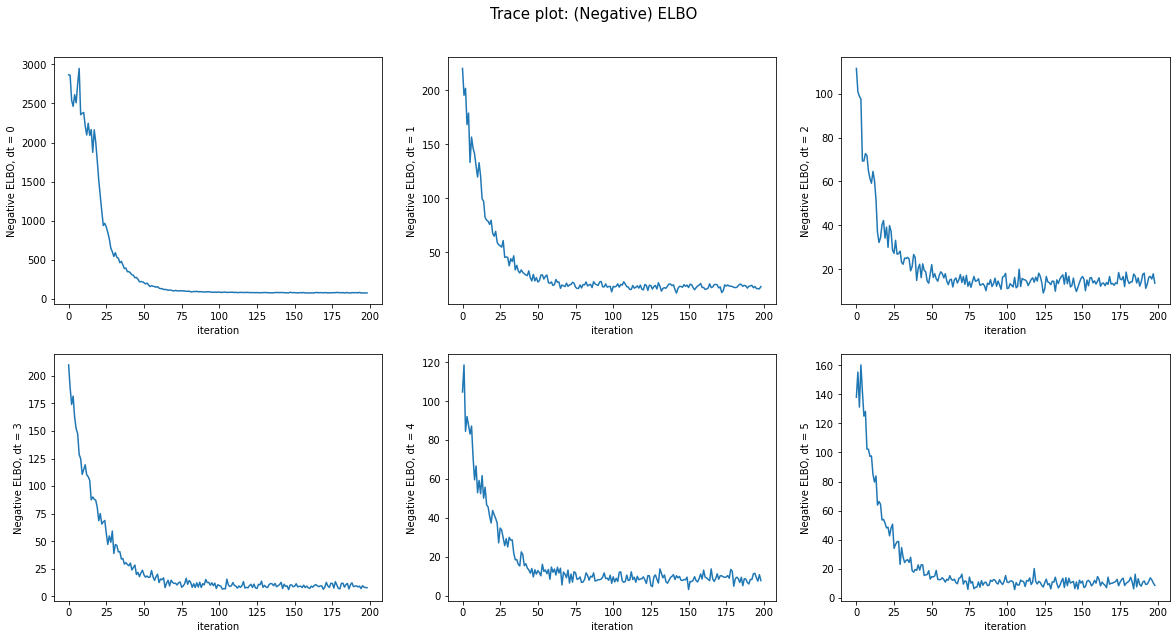

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

In [21]:
elbo_traces[:, 100:].mean(axis=1)

array([79.57972651, 18.18162135, 14.40542103,  9.40440344,  9.01414911,
       10.45693494, 15.22853563, 11.11823825])

Trace plot: KL divergence

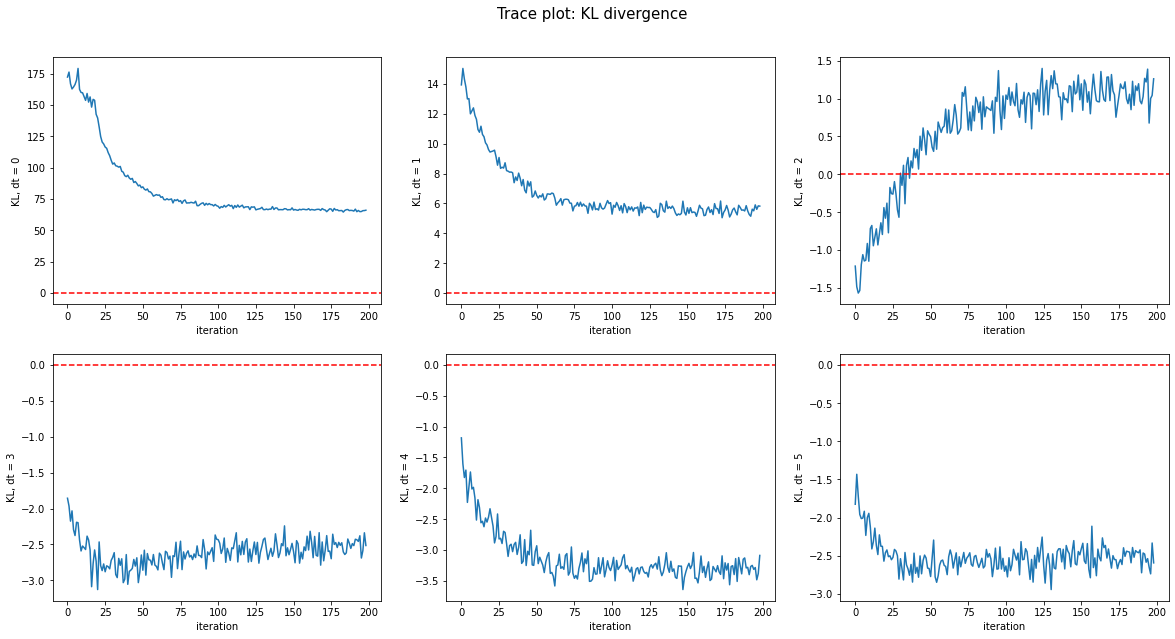

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

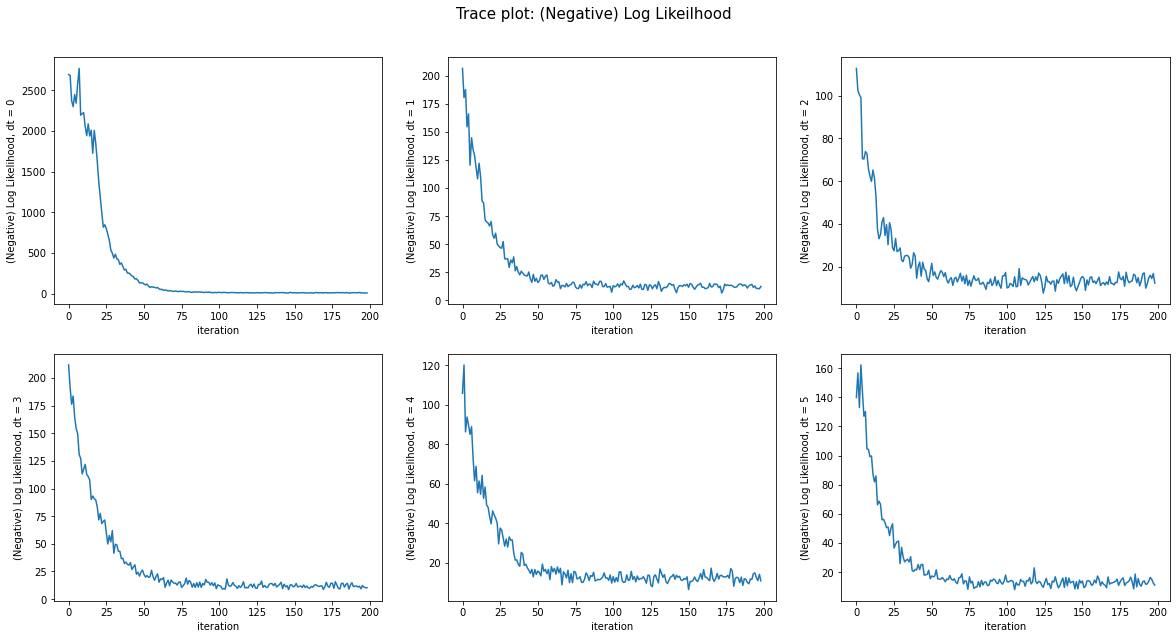

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(NLL_traces[t, :])), -1 * NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

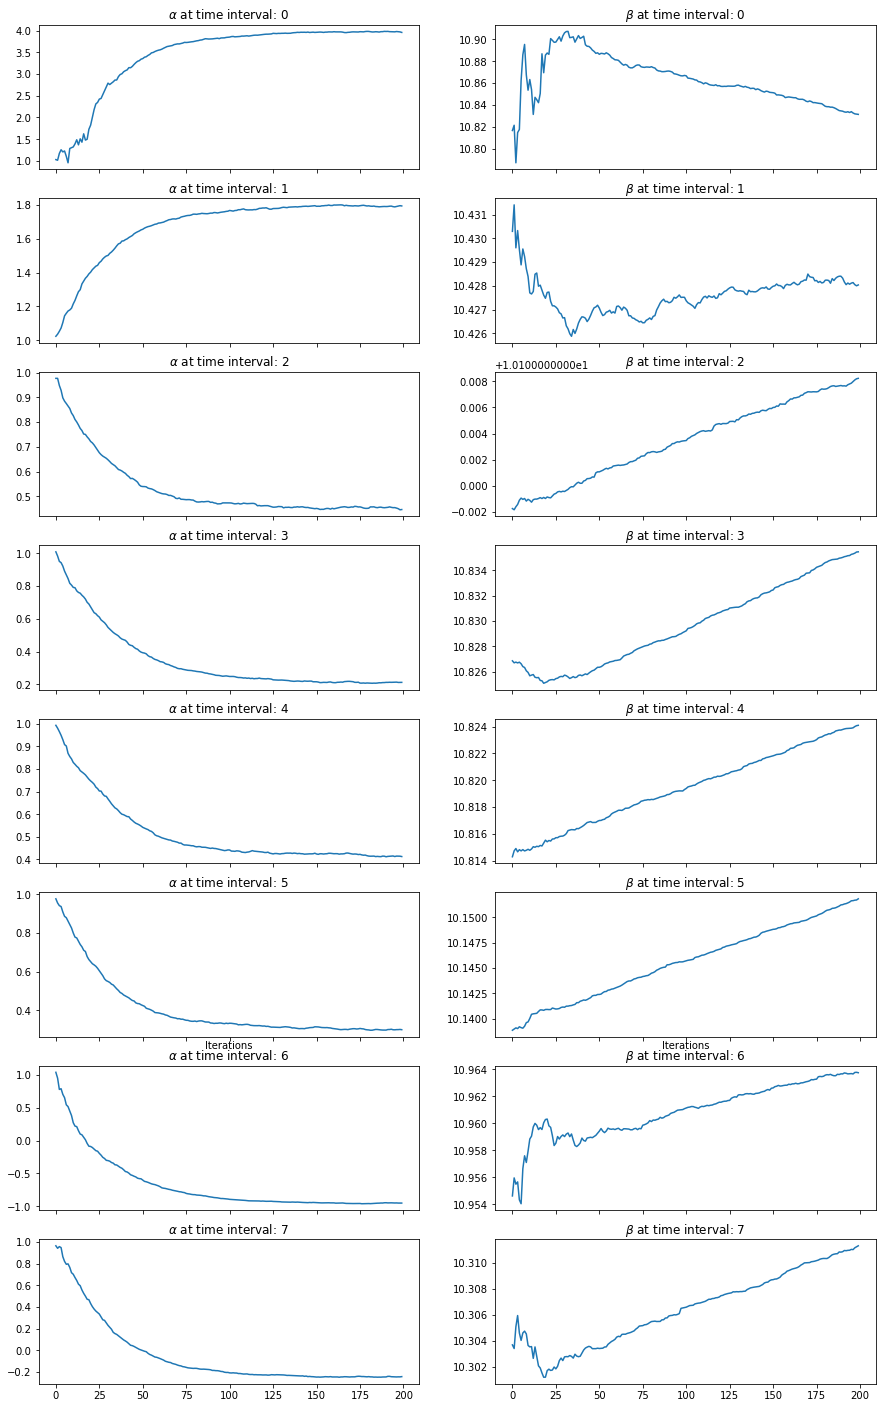

In [14]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=2, figsize=(15, 25), sharex='all')
names = [r'$\alpha$', r'$\beta$']
for j, ax in enumerate(ax.ravel()):
    i = j % 2
    t = j // 2
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

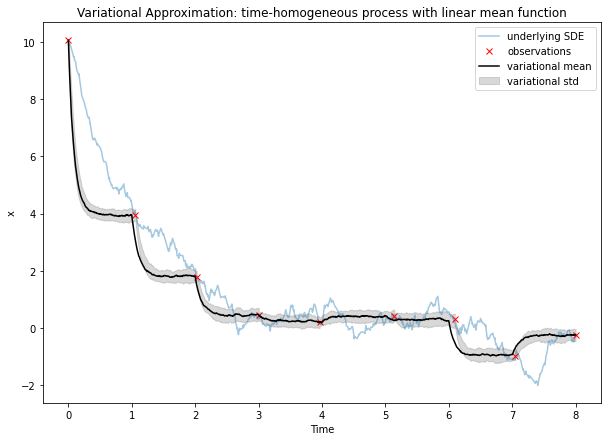

In [16]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-homogeneous process with linear mean function")
plt.show()